![alt text](../img/general/header.png)

# Introducción al Aprendizaje Automático

El objetivo de este laboratorio es introducir los conceptos básicos involucrados en el entrenamiento y verificación de los modelos basados en aprendizaje automaático. 
Para esto, se hará uso de MNIST y CFAR-10 dataset. 
Las métricas a obtener incluyen: matriz de confusión, ROC, accuracy. 



💡 Las redes neuronales están compuestas por parámetros e hiperparámetros. Los parámetros se aprenden durante el entrenamiento, como los pesos de los filtros en una red neuronal convolucional (CNN). En contraste, los hiperparámetros son definidos por el usuario antes de que comience el entrenamiento. Los hiperparámetros especifican tanto la arquitectura, como el número de capas, el número de filtros por capa y las dimensiones de los filtros, así como el proceso de aprendizaje, incluyendo la tasa de aprendizaje, el tamaño del lote, el número de épocas y los criterios de detención temprana.

Los principales pasos involucrados en el proceso de entrenamiento y prueba se ilustran en la siguiente imagen, junto con sus funciones correspondientes.

Los dos primeros pasos se centran en definir los hiperparámetros y configurar la arquitectura del aprendizaje automático. Posteriormente, un resumen del modelo ayuda a revisar cómo fue construido.

Una vez que se crea el modelo, se configuran parámetros como el optimizador, la función de pérdida y las métricas utilizando la función _model.compile()_.

Finalmente, el entrenamiento se lleva a cabo con la función _model.fit()_, donde se especifican el conjunto de datos, el tamaño del lote (batch), el número de épocas (epochs) y los callbacks, entre otros.

![alt text](../img/lab01/steps_ml.png)

### Librerías


In [30]:
import os
import numpy as np
from numpy import array

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam

## Datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Habilitación de GPU 

In [31]:
# GPU 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

GPUs:  1


### Carga de dataset

En este ejercicio se va a emplear MNIST dataset para efectuar el entrenamiento del modelo ML para clasificación. MNIST está compuesto por 10 dígitos, del 0 al 9.

![alt text](../img/lab01/01_lab_mnist.png)

In [32]:
# Carga del dataset, dividido en trainig y testing (data y clase)
(x_train, y_train),(x_test, y_test) = mnist.load_data()


### Inspección del dataset

Visualización de los elementos que componen el dataset

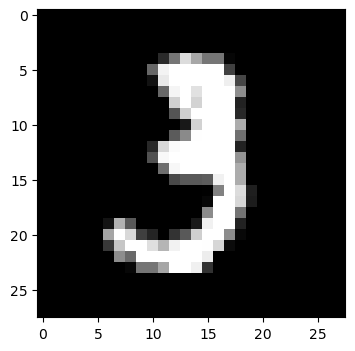

In [33]:
# Indice de la imagen (N) del conjunto de datos.Variando este valor se modifica la imagen a mostrar
N = 10

# Tamaño de la imagen a mostrar
plt.figure(figsize=(4,4))

plt.imshow(x_train[N], cmap='gray')


####  📝 Ejercicio: 

Cambie el valor de **N** para obervar los distintos elementos del dataset

In [34]:
# "Forma" de la variable x_train.
# Esto es necesario para saber la cantidad de elementos con los que contamos y la dimensión del los mismos.
# En este caso, X_train contiene 60000 elementos de 28x28 píxeles.
# El tamaño de la imagen es importante porque necesitaremos usarlo en la construcción de la arquitectura basada en ML.

x_train.shape

(60000, 28, 28)

### Pre-procesamiento

Cuando trabajamos con imágenes, generalmente estas deben someterse a un pre-procesamiento básico que corresponde normalizar los valores entre [0, 1], debido a que los píxeles que la componen se encuentran en el rango [0, 255]. Esto se logra mediante una simple división del valor de los píxeles originales por 255.

En este caso lo vamos a aplicar a las variables que contienen las imágenes, *x_train* y *x_test*; debido a que *y_train* e *y_test* tienen el valor de la clase correspondiente.


In [35]:
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0

### Arquitectura MLP

In [36]:
# Obtención del ancho y altura de la imagen 

w = x_train_norm.shape[1]
h = x_train_norm.shape[2]


In [37]:
# Número de clases en el dataset
n_classes = 10


In [38]:
# Definición de la arquitectura basada en MLP 

model= Sequential([

    Flatten(input_shape=(w, h)),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')

])


####  📝 Ejercicio: 

Cuál es la función de la capa *flatten*?

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                330       
Total params: 219,818
Trainable params: 219,818
Non-trainable params: 0
_________________________________________________________________


### Model compile

- **loss:**  métrica que mide qué tan lejos están las predicciones del modelo de los valores reales.

    - sparse_categorical_crossentropy: cuando la etiqueta (o clase) se encuentra en valores enteros. 
    - categorical_crossentropy: cuando la etiqueta (o clase) se encuentra en valores one-hot encoded. 

- **optimizer:** algoritmo que ajusta los pesos de la red neuronal para minimizar la función de pérdida.

    - SGD (Descenso de gradiente estocástico)
    - Adam (Adaptative Moment Estimation, balancea velocidad y estabilidad)

- **learning rate:** hiperparámetro que controla qué tan grandes son los ajustes que hace el optimizador en los pesos del modelo en cada iteración.

- **metrics:** valores adicionales que se monitorean durante el entrenamiento para evaluar el desempeño del modelo. Por ejemplo, accuracy (precisión, usada en clasificación)

In [40]:
lr = 0.001
# op = Adam(lr)
op = SGD(lr)

model.compile(loss='sparse_categorical_crossentropy', optimizer=op, metrics=['accuracy'])

### Entrenamiento

- **x_train_norm:** conjunto de datos normalizados obtenidos a partir de aplicar una transformación a x_train.

- **y_train:** etiquetas (o valores esperados) correspondientes a los datos de entrenamiento.

- **batch:** número de muestras que se procesan antes de actualizar los pesos del modelo.

- **epochs:** número de veces que el modelo recorrerá completamente el conjunto de datos de entrenamiento.

- **validation_split:** porcentaje del conjunto de datos de entrenamiento (x_train, y_train) que se reserva para validación.

In [41]:
history = model.fit(x_train_norm, y_train, epochs= 32, batch_size = 50, validation_split=0.2)

Epoch 1/32
960/960 [==============================] - 2s 2ms/step - loss: 2.2512 - accuracy: 0.1772 - val_loss: 1.9451 - val_accuracy: 0.5059
Epoch 2/32
960/960 [==============================] - 1s 1ms/step - loss: 1.8330 - accuracy: 0.5621 - val_loss: 1.4224 - val_accuracy: 0.7195
Epoch 3/32
960/960 [==============================] - 1s 1ms/step - loss: 1.3152 - accuracy: 0.7258 - val_loss: 0.9672 - val_accuracy: 0.7940
Epoch 4/32
960/960 [==============================] - 1s 1ms/step - loss: 0.9199 - accuracy: 0.7870 - val_loss: 0.7115 - val_accuracy: 0.8340
Epoch 5/32
960/960 [==============================] - 1s 1ms/step - loss: 0.7001 - accuracy: 0.8257 - val_loss: 0.5754 - val_accuracy: 0.8577
Epoch 6/32
960/960 [==============================] - 1s 2ms/step - loss: 0.5841 - accuracy: 0.8468 - val_loss: 0.4960 - val_accuracy: 0.8733
Epoch 7/32
960/960 [==============================] - 1s 1ms/step - loss: 0.5108 - accuracy: 0.8626 - val_loss: 0.4446 - val_accuracy: 0.8836
Epoch 

In [42]:
# Evaluación del modelo
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

313/313 [==============================] - 0s 1ms/step - loss: 30.8611 - accuracy: 0.9323

Test accuracy: 0.9323


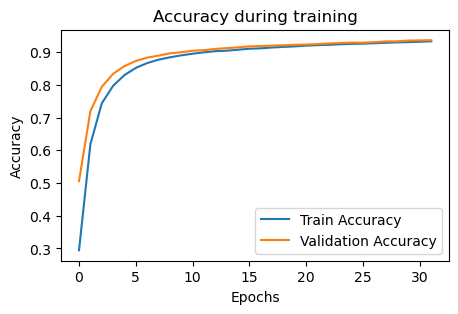

In [43]:
# Gráfico de accuracy over epochs
plt.figure(figsize=(5,3))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy during training')
plt.legend()
plt.show()

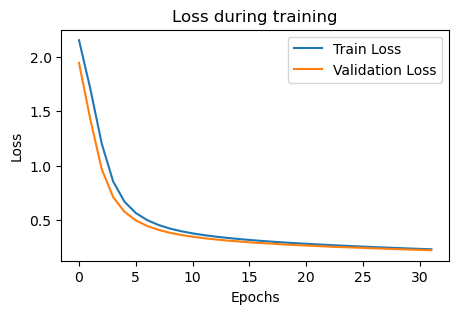

In [44]:
# Gráfico de loss over epochs
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.legend()
plt.show()

### Prueba de inferencia

Una de las pruebas fundamentales para verificar el funcionamiento del modelo entrenado es la prueba por imagen, de manera independiente. 

Predicted Class: 9 - True label: 9


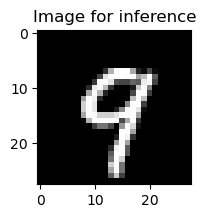

In [45]:

index = 12

plt.figure(figsize=(2,2))
plt.imshow(x_test[index], cmap='gray')
plt.title("Image for inference")

x_test_norm_reshaped = x_test_norm[index].reshape(-1, 28,28)

y_pred = model.predict(x_test_norm_reshaped)

y_pred = np.argmax(y_pred) 
print(f"Predicted Class: {y_pred} - True label: {y_test[index]}")

#### Métricas

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score

y_pred = model.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)



#### Reporte de métricas

In [47]:
report_classification = classification_report(y_test, y_pred_labels, digits=4) #, output_dict=True

In [48]:
print(report_classification)

print('Accuracy avg     %.4f' % test_acc)

              precision    recall  f1-score   support

           0     0.9351    0.9857    0.9598       980
           1     0.9770    0.9718    0.9744      1135
           2     0.9257    0.9293    0.9275      1032
           3     0.9150    0.9267    0.9208      1010
           4     0.9289    0.9318    0.9304       982
           5     0.9621    0.8543    0.9050       892
           6     0.9362    0.9499    0.9430       958
           7     0.9652    0.9163    0.9401      1028
           8     0.8725    0.9271    0.8990       974
           9     0.9097    0.9187    0.9142      1009

    accuracy                         0.9323     10000
   macro avg     0.9327    0.9312    0.9314     10000
weighted avg     0.9332    0.9323    0.9322     10000

Accuracy avg     0.9323


#### Matriz de confusión

La **matriz de confusión** se puede generar para analizar el rendimiento del modelo en términos de precisión. Presenta los resultados de las predicciones en un formato matricial, comparando los valores reales (etiquetas verdaderas) con los valores predichos. En un problema de clasificación binaria, la matriz de confusión es una cuadrícula de 2x2 con las siguientes partes:

- **Verdaderos Positivos (VP)**: Número de instancias en las que el modelo predijo correctamente la clase positiva.

- **Verdaderos Negativos (VN)**: Número de instancias en las que el modelo predijo correctamente la clase negativa.

- **Falsos Positivos (FP)**: Número de instancias en las que el modelo predijo incorrectamente la clase positiva.

- **Falsos Negativos (FN)**: Número de instancias en las que el modelo predijo incorrectamente la clase negativa.

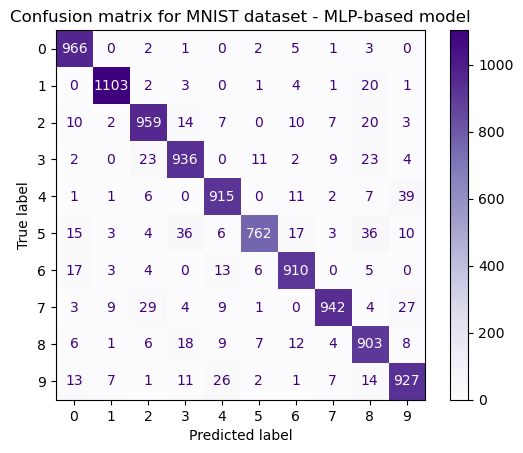

In [49]:

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = 'Purples')
plt.title('Confusion matrix for MNIST dataset - MLP-based model')
plt.show()

#### ROC curve

0.9624081426031069


Text(0, 0.5, 'True Positive Rate')

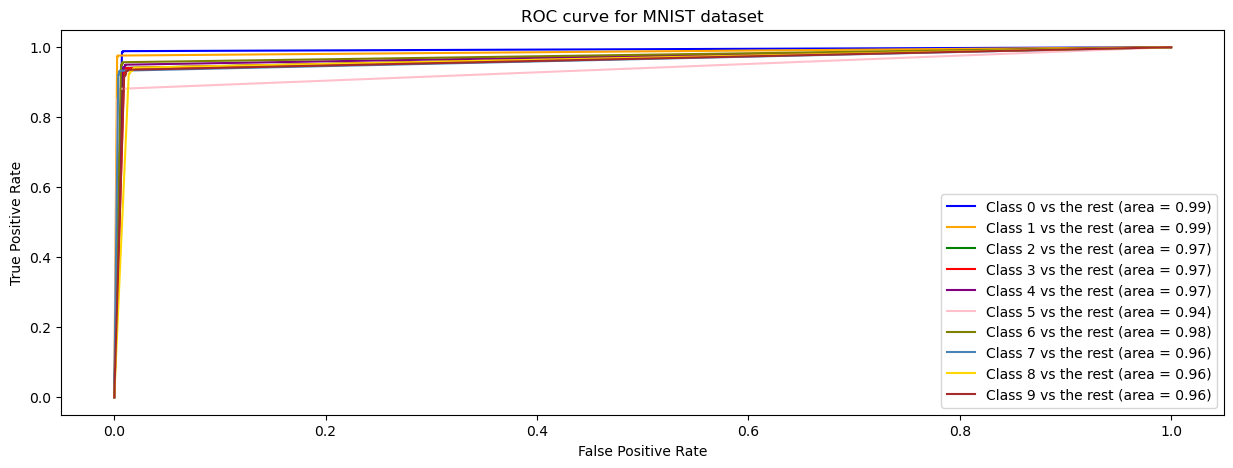

In [50]:
import matplotlib.colors as mcolors

# compute ROC curve and ROC area for each class

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
  fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs[:,i], pos_label=i) 
  roc_auc[i] = auc(fpr[i], tpr[i])

## roc_auc_score require the y_test and y_pred array be in catecorical mode
ycat_test = keras.utils.to_categorical(y_test, 10)
ycat_test_pred = keras.utils.to_categorical(y_pred, 10)

print(roc_auc_score(ycat_test, ycat_test_pred, multi_class='ovr', average='weighted'))

# Plot with for-loop
color = ['blue','orange', 'green', 'red', 'purple', 'pink', 'olive', 'steelblue', 'gold', 'brown' ]
plt.figure(figsize=(15,5))
for g in range (10):
  plt.plot(fpr[g], tpr[g], color=color[g], label='Class %d vs the rest (area = %.2f)' % (g, roc_auc[g]))

# Plot by element
# plt.plot(fpr[0], tpr[0], color='blue', label='Class 0 vs the rest (area = %.2f)' % roc_auc[0])
# plt.plot(fpr[1], tpr[1], color='red', label='Class 1 vs the rest (area = %.2f)' % roc_auc[1])
# plt.plot(fpr[2], tpr[2], color='green', label='Class 2 vs the rest (area = %.2f)' % roc_auc[2])
# plt.plot(fpr[3], tpr[3], color='orange', label='Class 3 vs the rest (area = %.2f)' % roc_auc[3])

plt.title('ROC curve for MNIST dataset')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

####  📝 Ejercicio: 

Varíe el valor de batch, epoch, y learning rate. Obtenga las gráficas correspondientes. Qué conclusiones puede obtener al variar estos parámetros?

#### Guardar el modelo

In [51]:
model.save('../models/mnistModel_FC.h5')

---

#### Uso de One-Hot Encoding

El One-Hot Encoding es una técnica para convertir etiquetas categóricas en un formato numérico que las redes neuronales pueden procesar.

Por ejemplo, para MNIST, tenemos las clases 0, 1, 2, 3 ... hasta 9. En one-hot encoding estas se representan de la siguiente manera: 

0 -> [1, 0, 0, 0, ...]

1 -> [0, 1, 0, 0, ...]

2 -> [0, 0, 1, 0, ...]

3 -> [0, 0, 0, 1, ...]

y asi sucesivamente con todas las categorias presentes en el dataset. 


In [52]:
# One-hot encode labels
y_train = to_categorical(y_train, num_classes = n_classes)
y_test = to_categorical(y_test, num_classes = n_classes)


In [29]:
y_train.shape

(10000, 10, 10, 10)

In [ ]:
# Uso de categorical_crossentropy loss 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train_norm, y_train, epochs= 16, validation_split=0.2)

In [ ]:
# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Plot loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

-----

### CIFAR-10 para CNN

Vamos a repetir el procedimiento anterior pero haciendo uso de CIFAR-10 dataset. En este caso, vamos a emplear una arquitectura badada en 2D-CNN 

![alt text](../img/lab01/01_lab_cifar10.png)


In [ ]:
# Carga del dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
# Tamaño de la imagen a mostrar
plt.figure(figsize=(2,2))

# La imagen es el elemento N del conjunto de datos 
N = 100
plt.imshow(x_train[N])


In [ ]:
# Normalizacion del dataset
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0

In [ ]:
x_train_norm.shape

In [ ]:

model = Sequential([

    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)), 
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Reduce overfitting
    
    Dense(10, activation='softmax')
])


In [ ]:
# Compilar el modelo
op = Adam(0.001)
model.compile(optimizer=op,
              loss='sparse_categorical_crossentropy',   # Usar 'sparse_categorical_crossentropy' porque las etiquetas NO están one-hot encoded
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=32,  validation_split=0.2, batch_size=64)


In [ ]:
# Evaluar el modelo
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")


In [ ]:
# Graficar accuracy deurante el entrenamiento
plt.figure(figsize=(10,3))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

--------------

####  📝 Ejercicios: 


- Computar las métricas para CIFAR-10.

- Para MNIST, reemplazar la capa _Flatten_ en la definicion del modelo por _Dense_. Para este paso, la imagen se debe convertir en un vector de 1D. 

- Repetir el procedimiento anterior par fashion MNIST y CIFAR-100 datasets. 

- Obtener las métricas pertinentes para verificar el rendimiento del modelo.

- Para CIFAR-10 seleccione 2 clases e implemente un clasificador binario.

![alt text](../img/lab01/01_lab_fashionmnist.png)

In [ ]:
# Carga de Fashion MNIST dataset

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
# Carga de CIFAR-100 dataset

(x_train, y_train), (x_test, y_test) = cifar100.load_data()